In [38]:
# Python 3.7.7에서 테스트 하였습니다.
# 라이브러리 설치
# import sys
# !{sys.executable} -m pip install numpy pandas matplotlib
# !{sys.executable} -m pip install pyfpgrowth

     |████████████████████████████████| 1.6MB 809kB/s 
  Created wheel for pyfpgrowth: filename=pyfpgrowth-1.0-py2.py3-none-any.whl size=5479 sha256=76ec95adb1703599fdffc447003f73740259bea0f4fbfd6faca34faacea87098
  Stored in directory: /Users/seokje/Library/Caches/pip/wheels/3b/3f/0d/a04bb8b17887c1eca7d0f1a48d4aa0c09c96eb221ff7fa56c1
Successfully built pyfpgrowth


In [7]:
# Count by single group
import pandas as pd

df = pd.read_csv('../data/chatlogs.csv')
df = pd.pivot_table(df, index=['intent'], values=['userId'], aggfunc=[len], fill_value=0)
print(df.head())

len
            userId
intent            
alarm            2
application      5
array            9
bandwidth        5
bus              3


In [6]:
# Count by multiple groups
import pandas as pd

df = pd.read_csv('../data/chatlogs.csv')
df = pd.pivot_table(df,index=['entityName','entityValue'],values=["userId"],aggfunc=[len],fill_value=0,margins=True)
print(df.head())

len
                                    userId
entityName entityValue                    
Bacon      Ergonomic Rubber Chips        1
           Fantastic Fresh Sausages      1
           Incredible Wooden Bacon       1
           Intelligent Frozen Mouse      1
           Rustic Steel Gloves           1


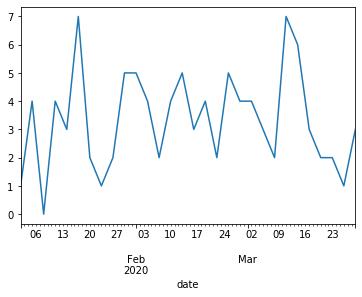

In [6]:
# Count by single group: date
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../data/chatlogs.csv')
df['date']=pd.to_datetime(df['createdAt'],format='%Y%m%d %H:%M')
df.date = df.date.dt.tz_convert('Asia/Seoul')
df1 = df.set_index('date')

df1 = df.set_index('date').resample('3D')['userId'].count()

df1.plot()
plt.show()

In [13]:
import pandas as pd

df = pd.read_csv('../data/chatlogs.csv',sep=',')
df1 = df.groupby(['entityName','entityValue'])['userId'].agg(['count'])
df2 = (df1 / df1.groupby(level=0).sum() * 100).round(2)
df2.head()

count
entityName entityValue                    
Bacon      Ergonomic Rubber Chips     20.0
           Fantastic Fresh Sausages   20.0
           Incredible Wooden Bacon    20.0
           Intelligent Frozen Mouse   20.0
           Rustic Steel Gloves        20.0

In [3]:
# Get Session id
# https://stackoverflow.com/questions/54850249/how-to-set-session-for-user-basing-on-time-difference-in-pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('../data/chatlogs_latest_14days.csv')
df['date']=pd.to_datetime(df['createdAt'],format='%Y%m%d %H:%M')
df.date = df.date.dt.tz_convert('Asia/Seoul')
df['timestamp'] = df.date.values.astype(np.int64) // 10 ** 9 # ts: timestamp

df1 = df[['userId', 'date', 'intent', 'timestamp']]

# Sort userId ASC, date DESC
df2 = df1.sort_values(['userId','timestamp'], ascending=[True,True])
df3 = df2
# df3 = df2[df2.userId == '9e4e1751-bbbd-414f-924e-0979cb580a36']

# Timestamp diff in seconds
diff_timestamp = df3.groupby('userId')['timestamp'].diff()

# indexes where new session_id will be created (for example here, The session interval is 48 hours.)
new_session = (diff_timestamp.isnull()) | (diff_timestamp > 60 * 60 * 13)

df3['session_id'] = df3.loc[new_session, ['userId', 'timestamp']] \
    .groupby('userId').rank(method='first').astype(int)

# Propagate last valid observation forward (replace NaN)
df3['session_id'] = df3['session_id'].fillna(method='ffill').astype(int)
df3.head()

df3['rowNum'] = df3.groupby(['userId']).cumcount() + 1
pivot = df3.pivot_table(values=['intent'], index='userId', columns='rowNum', aggfunc='first')
pivot

# sessions = df3.sort_values(['userId','date'], ascending=[True,True]) \
#     .groupby(['userId','intent','session_id']).first()

# sessions



intent  \
rowNum                                               1     
userId                                                     
000164d9-8f1a-434c-bfea-442f396a7d9c   StartOver_Welcome   
0001a33c-1dc7-456c-a652-e02557601db0     ChatbotNavi_faq   
00033431-a262-4843-a266-81bfeccc2507   StartOver_Welcome   
00049b49-510e-43f3-86c0-95b098c2c9eb  EP_start_epromoter   
00074c85-abe2-446d-a70e-a8f231db2d84   StartOver_Welcome   
...                                                  ...   
zyw9swusfg                            EP_start_epromoter   
zyzjktwedh                            EP_start_epromoter   
zz722x6tmh                             FAQ_payment_issue   
zzohvm9jtj                             StartOver_Welcome   
zzyvc2h9ch                                  adm_KF_ZFlip   

                                                                   \
rowNum                                                        2     
userId                                                              
000164d9-8f1a-434c-bfea-442f396a7d9c                          NaN   
0001a33c-1dc7-456c-a652-e02557601db0              FAQ_mobile_care   
00033431-a262-4843-a266-81bfeccc2507                          NaN   
00049b49-510e-43f3-86c0-95b098c2c9eb                          NaN   
00074c85-abe2-446d-a70e-a8f231db2d84            StartOver_Welcome   
...                                                           ...   
zyw9swusfg                                                    NaN   
zyzjktwedh                                      StartOver_Welcome   
zz722x6tmh                            smalltalk.agent.why_created   
zzohvm9jtj                                                    NaN   
zzyvc2h9ch                              smalltalk.greetings.hello   

                                                                 \
rowNum                                                      3     
userId                                                            
000164d9-8f1a-434c-bfea-442f396a7d9c                        NaN   
0001a33c-1dc7-456c-a652-e02557601db0                  StartOver   
00033431-a262-4843-a266-81bfeccc2507                        NaN   
00049b49-510e-43f3-86c0-95b098c2c9eb                        NaN   
00074c85-abe2-446d-a70e-a8f231db2d84                        NaN   
...                                                         ...   
zyw9swusfg                                                  NaN   
zyzjktwedh                                      adm_thom_browne   
zz722x6tmh                            SiteNavi_customer_service   
zzohvm9jtj                                                  NaN   
zzyvc2h9ch                                adm_obf_benefit_ZFlip   

                                                                          \
rowNum                                            4                  5     
userId                                                                     
000164d9-8f1a-434c-bfea-442f396a7d9c              NaN                NaN   
0001a33c-1dc7-456c-a652-e02557601db0       adm_KF_S20                NaN   
00033431-a262-4843-a266-81bfeccc2507              NaN                NaN   
00049b49-510e-43f3-86c0-95b098c2c9eb              NaN                NaN   
00074c85-abe2-446d-a70e-a8f231db2d84              NaN                NaN   
...                                               ...                ...   
zyw9swusfg                                        NaN                NaN   
zyzjktwedh                            adm_thom_browne    ChatbotNavi_faq   
zz722x6tmh                                   fallback                NaN   
zzohvm9jtj                                        NaN                NaN   
zzyvc2h9ch                            ChatbotNavi_faq  StartOver_Welcome   

                                                             \
rowNum                                                  6     
userId                                                        
000164d9-8f1a-434c-bfea-442f396a7d9c             

In [2]:
# Sankey chart using plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

df = pd.read_csv('../data/chatlogs_latest_21days.csv')
df['date']=pd.to_datetime(df['createdAt'],format='%Y%m%d %H:%M')
df.date = df.date.dt.tz_convert('Asia/Seoul')
df['timestamp'] = df.date.values.astype(np.int64) // 10 ** 9 # ts: timestamp

df1 = df[['userId', 'date', 'intent', 'timestamp']]

intents = pd.DataFrame(data=df1.intent.unique(), columns=['intent'])
# intents

df2 = df1.sort_values(['userId','timestamp'], ascending=[True,True])
df2['prev_intent'] = df2.groupby('userId')['intent'].shift()
# df2[df2.prev_intent == 'ChatbotNavi_faq']
# df2[df2.userId == '70fea51c-799b-4aa9-b649-f50cfe5e68ef']

df3 = df2[df2.userId == '70fea51c-799b-4aa9-b649-f50cfe5e68ef']
df4 = df3.groupby(['prev_intent', 'intent'], as_index=False).size()
df5 = df4.reset_index(name='value')
df5['source'] = df5['prev_intent'].map(lambda x: intents[intents['intent'] == x].index[0])
df5['target'] = df5['intent'].map(lambda x: intents[intents['intent'] == x].index[0])

# df6 = df5.head(100)
# df6

# Draw Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = intents['intent'],
      color = "blue"
    ),
    link = dict(
      source = df5['source'], # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = df5['target'],
      value = df5['value']
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()


In [60]:
import pandas as pd
df = pd.read_csv('../data/df4.csv')
type(df)

# intents = pd.DataFrame(data=df1.intent.unique(), columns=['intent'])
# for row in df.prev_intent:
#     print(row)


pandas.core.frame.DataFrame

In [12]:
# Sankey chart using plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

df = pd.read_csv('../data/chatlogs_latest_21days.csv')
df['date']=pd.to_datetime(df['createdAt'],format='%Y%m%d %H:%M')
df.date = df.date.dt.tz_convert('Asia/Seoul')
df['timestamp'] = df.date.values.astype(np.int64) // 10 ** 9 # ts: timestamp

df1 = df[['userId', 'date', 'intent', 'timestamp']]

intents = pd.DataFrame(data=df1.intent.unique(), columns=['intent'])
# intents

df2 = df1.sort_values(['userId','timestamp'], ascending=[True,True])
df2['prev_intent'] = df2.groupby('userId')['intent'].shift()
# df2[df2.prev_intent == 'ChatbotNavi_faq']
df2[df2.userId == '70fea51c-799b-4aa9-b649-f50cfe5e68ef']

,userId,date,intent,timestamp,prev_intent
152513,70fea51c-799b-4aa9-b649-f50cfe5e68ef,2020-02-23 23:58:33.505000+09:00,StartOver_Welcome,1582469913,NaN
153441,70fea51c-799b-4aa9-b649-f50cfe5e68ef,2020-02-23 23:58:37.788000+09:00,StartOver_Orientation,1582469917,StartOver_Welcome
152339,70fea51c-799b-4aa9-b649-f50cfe5e68ef,2020-02-23 23:58:42.327000+09:00,StartOver_Orientation2,1582469922,StartOver_Orientation
152514,70fea51c-799b-4aa9-b649-f50cfe5e68ef,2020-02-23 23:58:44.775000+09:00,StartOver_Orientation3,1582469924,StartOver_Orientation2
153442,70fea51c-799b-4aa9-b649-f50cfe5e68ef,2020-02-23 23:58:48.674000+09:00,Recommend_product_null,1582469928,StartOver_Orientation3
153443,70fea51c-799b-4aa9-b649-f50cfe5e68ef,2020-02-23 23:59:10.438000+09:00,Recommend_product,1582469950,Recommend_product_null
152516,70fea51c-799b-4aa9-b649-f50cfe5e68ef,2020-02-23 23:59:57.505000+09:00,Recommend_product_null,1582469997,Recommend_product
153444,70fea51c-799b-4aa9-b649-f50cfe5e68ef,2020-02-24 00:00:01.931000+09:00,Recommend_product,1582470001,Recommend_product_null
152342,70fea51c-799b-4aa9-b649-f50cfe5e68ef,2020-02-24 00:00:06.282000+09:00,StartOver,1582470006,Recommend_product
152517,70fea51c-799b-4aa9-b649-f50cfe5e68ef,2020-02-24 00:00:10.162000+09:00,Recommend_product_null,1582470010,StartOver


In [5]:
import pandas as pd
import numpy as np
import re

df = pd.read_csv('../data/chatlogs_latest_14days.csv')
# df['date'] = pd.to_datetime(df['createdAt'],format='%Y%m%d %H:%M')
# df.date = df.date.dt.tz_convert('Asia/Seoul')
# df['timestamp'] = df.date.values.astype(np.int64) // 10 ** 9 # ts: timestamp

# Sort userId ASC, date DESC
# df = df.sort_values(['userId','timestamp'], ascending=[True,True])
# df = df[df['userId'] == '657d45b4-6354-4c93-a511-bb761a115a1f']

def get_group_intent(value):
    str = value.lower()
    
    if re.search('Search_product', value, re.IGNORECASE):
        return 'Search_product'
    elif (re.search('(Recommend_product|strong_point)', value, re.IGNORECASE)):
        return 'Recommend_product'
    elif re.search('Search_event', value, re.IGNORECASE):
        return 'Search_event'
    elif re.search('KF', value, re.IGNORECASE):
        return 'Keyfeature'
    elif re.search('obf', value, re.IGNORECASE):
        return 'Order_benefit'
    elif re.search('^(FAQ|SiteNavi)', value, re.IGNORECASE):
        return 'FAQ'
    elif re.search('fallback', value, re.IGNORECASE):
        return 'fallback'
    elif re.search('^(adm)((?!Flagship).)*$', value, re.IGNORECASE):
        return 'adm'
    elif re.search('StartOver_welcome$', value, re.IGNORECASE):
        return 'StartOver_welcome'
    elif re.search('StartOver_Orientation', value, re.IGNORECASE):
        return 'StartOver_Orientation'
    elif re.search('StartOver$', value, re.IGNORECASE):
        return 'StartOver'
    elif re.search('smalltalk', value, re.IGNORECASE):
        return 'smalltalk'
    elif re.search('(Flagship|General)', value, re.IGNORECASE):
        return 'Flagship'
    elif re.search('ComInfo', value, re.IGNORECASE):
        return 'ComInfo'
    elif re.search('EP_start_epromoter', value, re.IGNORECASE):
        return 'ePromoter_start'
    elif re.search('EP_backto_chatbot', value, re.IGNORECASE):
        return 'ePromoter_end'
    elif re.search('(EPB|EP)_self_check', value, re.IGNORECASE):
        return 'chatbot_to_ePromoter'
    elif re.search('^(EPB|EP)', value, re.IGNORECASE):
        return 'ePromoter_ing'
    else:
        return value

# print (get_group_intent('EP_self_check'))

df['group'] = df['intent'].apply(get_group_intent)
df.to_csv('../data/group_intents.csv')



In [14]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/group_intents.csv')
df['date']=pd.to_datetime(df['createdAt'],format='%Y%m%d %H:%M')
df.date = df.date.dt.tz_convert('Asia/Seoul')
df['timestamp'] = df.date.values.astype(np.int64) // 10 ** 9 # ts: timestamp

df1 = df[['userId', 'date', 'group', 'timestamp']]

# Sort userId ASC, date DESC
df2 = df1.sort_values(['userId','timestamp'], ascending=[True,True])

# Timestamp diff in seconds
diff_timestamp = df2.groupby('userId')['timestamp'].diff()

# indexes where new session_id will be created (for example here, The session interval is 10 seconds.)
new_session = (diff_timestamp.isnull()) | (diff_timestamp > 2)

df2['session_id'] = df2.loc[new_session, ['userId', 'timestamp']] \
    .groupby('userId').rank(method='first').astype(int)

# Propagate last valid observation forward (replace NaN)
df2['session_id'] = df2['session_id'].fillna(method='ffill').astype(int)
df2['rowNum'] = df2.groupby(['userId']).cumcount() + 1

pivot = df2.pivot_table(values=['group'], index='userId', columns='rowNum', aggfunc='first')
# pivot.columns = ['.'.join(col).strip() for col in pivot.columns.values]
pivot.columns = ['_'.join(str(s).strip() for s in col if s) for col in pivot.columns]
pivot.reset_index(inplace=True)

# pivot
r = pivot.loc[:, :'group_15']
# r = r.sort_values(by ='intent_1')

r.to_csv('../data/pivot.csv',index=False)

In [11]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/pivot.csv', index_col=0)

# Sort userId ASC, date DESC
df = df.sort_values(by=list(df.loc[:, 'group_1':'group_15']))
# df.loc[:, :'group_15'].to_csv('../data/pivot_by_group_intent.csv', index=False)
df1 = df.loc[:, :'group_15'].copy()
df1['flow'] = df1.apply(lambda x: ','.join(x.dropna()), axis=1)
df1['flow'].to_csv('../data/pivot_concat.csv',index=False)


In [13]:
import pandas as pd

df = pd.read_csv('../data/pivot_concat.csv', index_col=0)
df = df.sort_values('flow')
df.to_csv('../data/pivot_concat_sorted.csv')


In [51]:
str = "ChatbotNavi_faq,ePromoter_start,fallback,ChatbotNavi_faq,ChatbotNavi_faq,StartOver,Recommend_product,Recommend_product,chatbot_to_ePromoter,StartOver,Search_product,fallback,Search_event,Search_event,chatbot_to_ePromoter"

stack = []  # keep track of ancestors ([0] - root, ..., [-1] - parent)
for line in x.splitlines():
    name = line.strip()
    level = line.count('\t')
    while len(stack) > level:
        stack.pop()
    node = Node(name=name, parent=stack[-1] if stack else None)
    node.save()
    stack.append(node)
    

NameError: name 'x' is not defined